# SIGNIFICADO DAS COLUNAS


* T2m [°C]: Temperatura do ar a 2 metros acima do solo, medida em graus Celsius.

* Td2m [°C]: Ponto de orvalho a 2 metros acima do solo, também em graus Celsius. O ponto de orvalho é a temperatura na qual o ar precisa ser resfriado para se tornar saturado com vapor de água.

* RH2m [%]: Umidade relativa do ar a 2 metros acima do solo, expressa em porcentagem. Indica a quantidade de vapor de água presente no ar em relação à quantidade máxima que o ar pode conter naquela temperatura.

* SLP [hPa]: Pressão atmosférica ao nível do mar, medida em hectopascals. É ajustada para o nível do mar para permitir comparações entre diferentes altitudes.
WS10m [m.s-1]: Velocidade do vento a 10 metros acima do solo, medida em metros por segundo.

* WD10m [°]: Direção do vento a 10 metros acima do solo, medida em graus, onde um valor de 0° indica vento vindo do norte e valores aumentam no sentido horário.

* Prec [mm]: Precipitação acumulada, medida em milímetros. Refere-se à quantidade total de precipitação que caiu durante um determinado período de tempo.

* SWDN: Radiação solar direta incidente na superfície, medida em watts por metro quadrado. É a quantidade de radiação solar que chega diretamente do sol.

* SWUP: Radiação solar refletida pela superfície, também medida em watts por metro quadrado. É a quantidade de radiação solar que é refletida de volta para o espaço.

* LWDN: Radiação de onda longa incidente na superfície, medida em watts por metro quadrado. É a radiação emitida pela atmosfera que é absorvida pela superfície terrestre.

* LWUP: Radiação de onda longa emitida pela superfície e que escapa para o espaço, medida em watts por metro quadrado. É a radiação térmica emitida pela superfície da Terra.

#BIBLIOTECAS

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera



#ANALISE EXPLORATORIA


##inicio

In [ ]:
df = pd.read_csv('SBLB_WRF_AZUL_00-24h.csv', delimiter=';')

y=df['WS10m [m.s-1]']

In [ ]:
print(df.head())


               Date   T2m [°C]  Td2m [°C]   RH2m [%]  SLP [hPa]  \
0  01/01/2020 00:00  26.644623  22.311699  78.208590        NaN   
1  01/01/2020 03:00  26.669098  22.152872  77.322490        NaN   
2  01/01/2020 06:00  26.530212  22.290398  78.641594        NaN   
3  01/01/2020 09:00  26.070190  22.615427  82.497480        NaN   
4  01/01/2020 12:00  26.284363  22.988417  83.361970        NaN   

   WS10m [m.s-1]  WD10m [°]  Prec [mm]       SWDN      SWUP       LWDN  \
0       9.579562  40.582268        NaN    0.00000   0.00000    0.00000   
1       9.577340  35.111675        NaN    0.00000   0.00000  392.63196   
2       8.610682  26.110786        NaN    0.00000   0.00000  395.83774   
3       7.593342  36.227753        NaN  186.18887 -15.27687  395.15860   
4       8.441726  33.750298        NaN  845.78796 -68.51840  398.81390   

        LWUP  
0    0.00000  
1 -457.31372  
2 -457.37784  
3 -457.11224  
4 -457.18536  


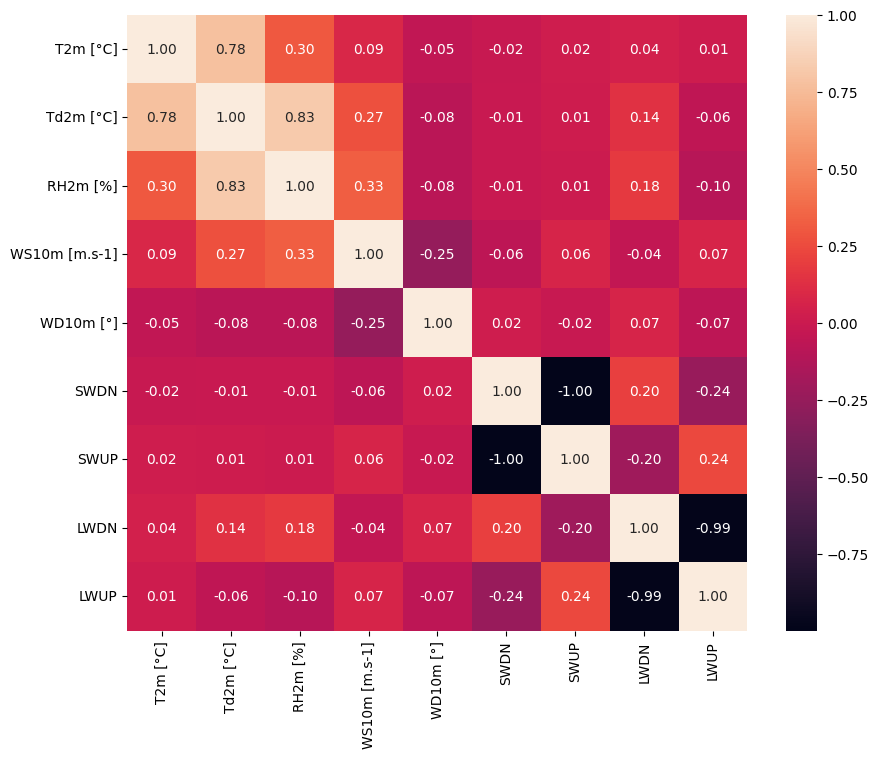

In [ ]:
# Matriz de correlação
colunas = ['T2m [°C]', 'Td2m [°C]', 'RH2m [%]', 'WS10m [m.s-1]', 'WD10m [°]', 'SWDN', 'SWUP', 'LWDN', 'LWUP']
matriz_correlacao = df[colunas].corr()


# Visualizar a matriz de correlação com heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacao, annot=True, fmt=".2f")
plt.show()


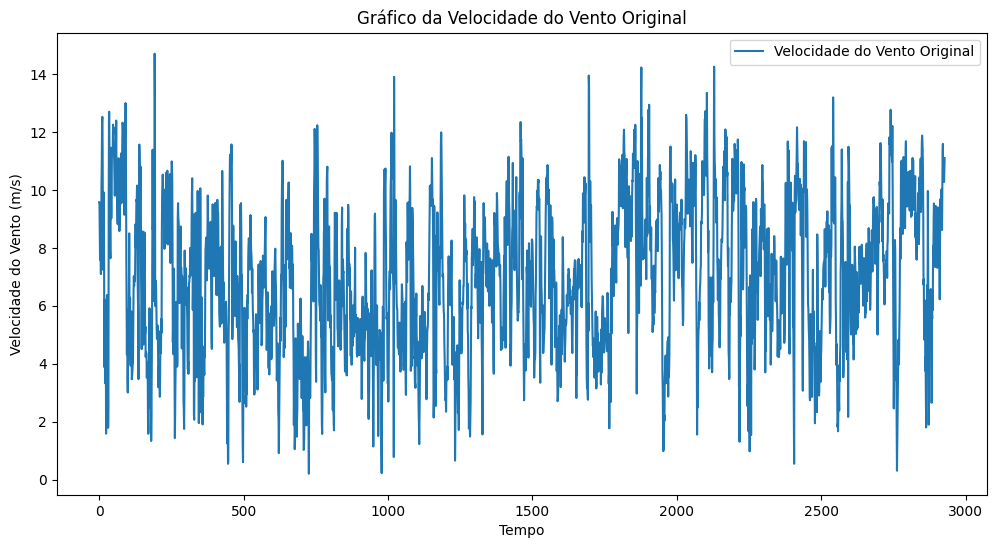

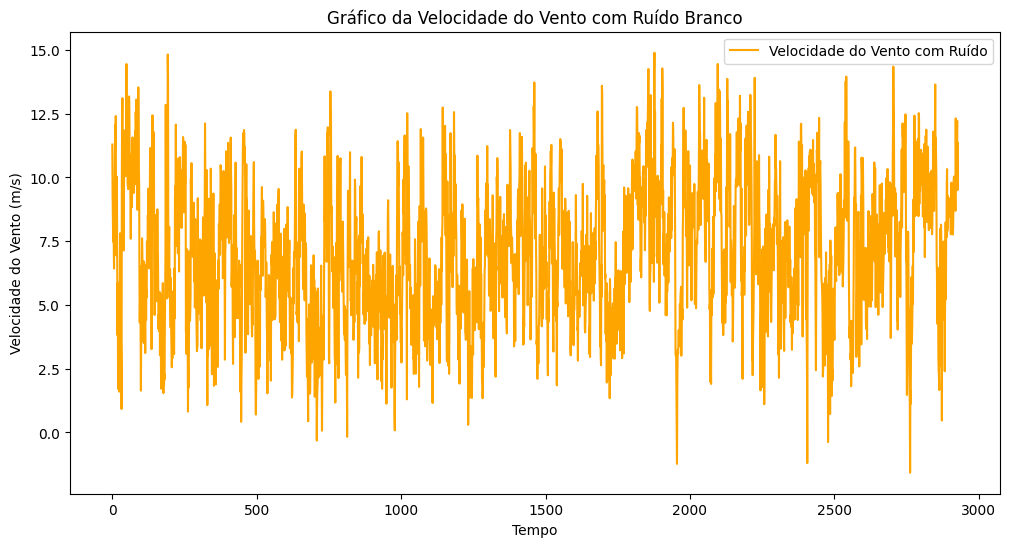

In [ ]:
#criando ruido branco
y = df['WS10m [m.s-1]'].values
noise = np.random.normal(loc=0, scale=1, size=y.shape)
y_noisy = y + noise
df['WS10m_noisy [m.s-1]'] = y_noisy


plt.figure(figsize=(12, 6))
plt.plot(df.index, df['WS10m [m.s-1]'], label='Velocidade do Vento Original')
plt.title('Gráfico da Velocidade do Vento Original')
plt.xlabel('Tempo')
plt.ylabel('Velocidade do Vento (m/s)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['WS10m_noisy [m.s-1]'], label='Velocidade do Vento com Ruído', color='orange')
plt.title('Gráfico da Velocidade do Vento com Ruído Branco')
plt.xlabel('Tempo')
plt.ylabel('Velocidade do Vento (m/s)')
plt.legend()
plt.show()


##Decomposição a série temporal


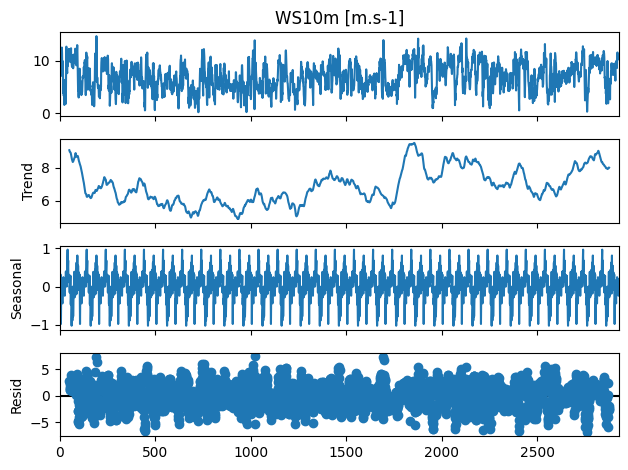

In [ ]:
ws10_series = df['WS10m [m.s-1]']
result = seasonal_decompose(df['WS10m [m.s-1]'], model='additive', period=100)
result.plot()
plt.show()


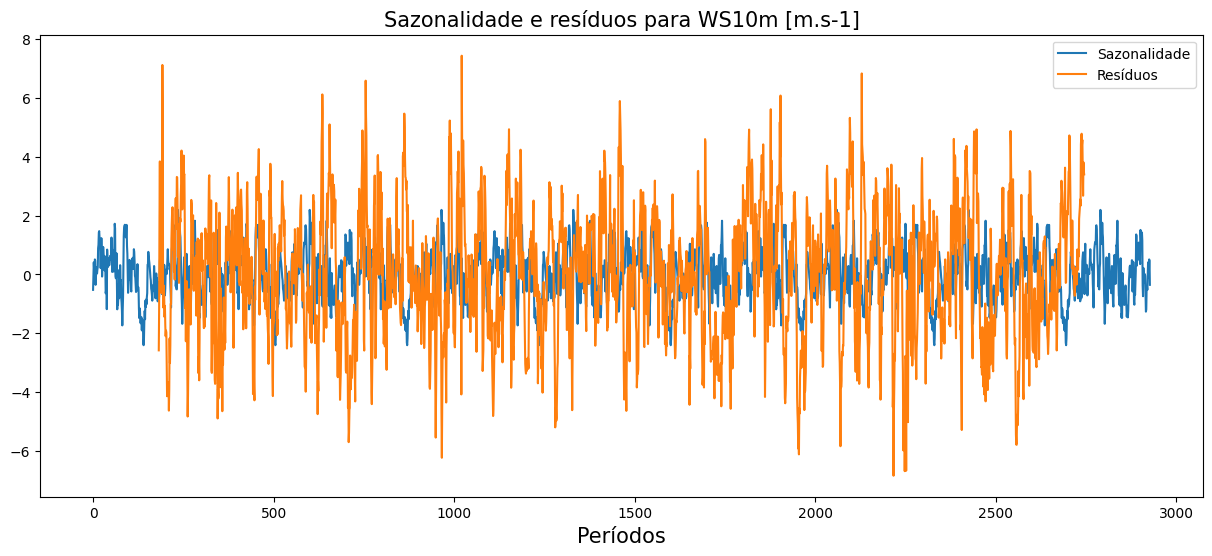

In [ ]:
result = seasonal_decompose(ws10_series, model='additive', period=365)
plt.figure(figsize=(15,6))
result.seasonal.plot(legend=True, label='Sazonalidade')
result.resid.plot(legend=True, label='Resíduos')
plt.xlabel('Períodos', size=15)
plt.title('Sazonalidade e resíduos para WS10m [m.s-1]', size=15)
plt.show()


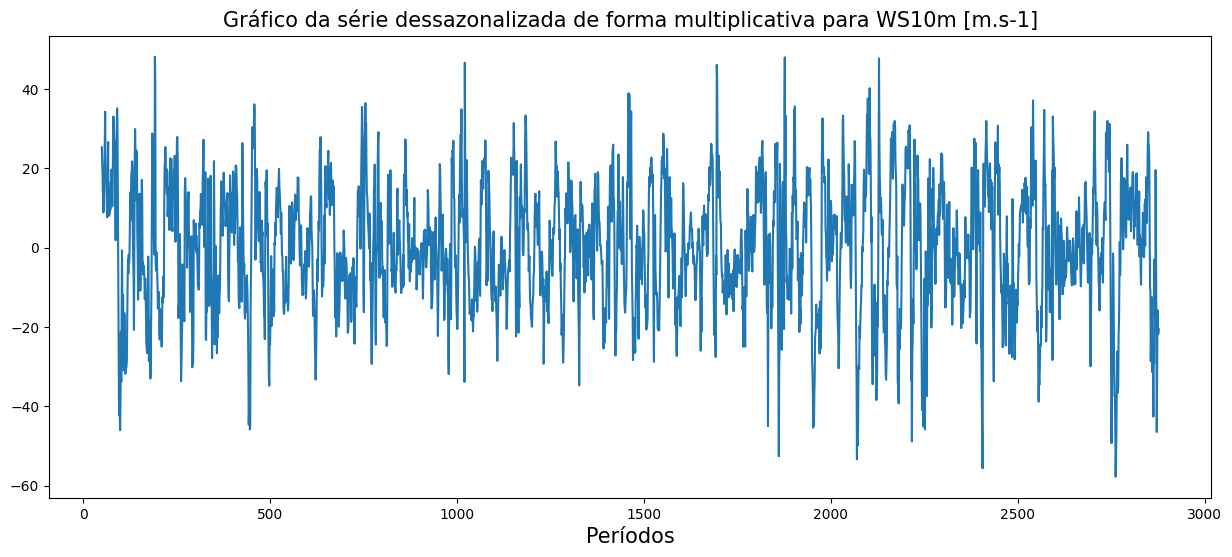

In [ ]:
#seasonal_decompose
ws10m_dessazonalizada = result.trend * result.resid

#dessazonalizada
plt.figure(figsize=(15,6))
ws10m_dessazonalizada.plot()
plt.xlabel('Períodos', size=15)
plt.title('Gráfico da série dessazonalizada de forma multiplicativa para WS10m [m.s-1]', size=15)
plt.show()


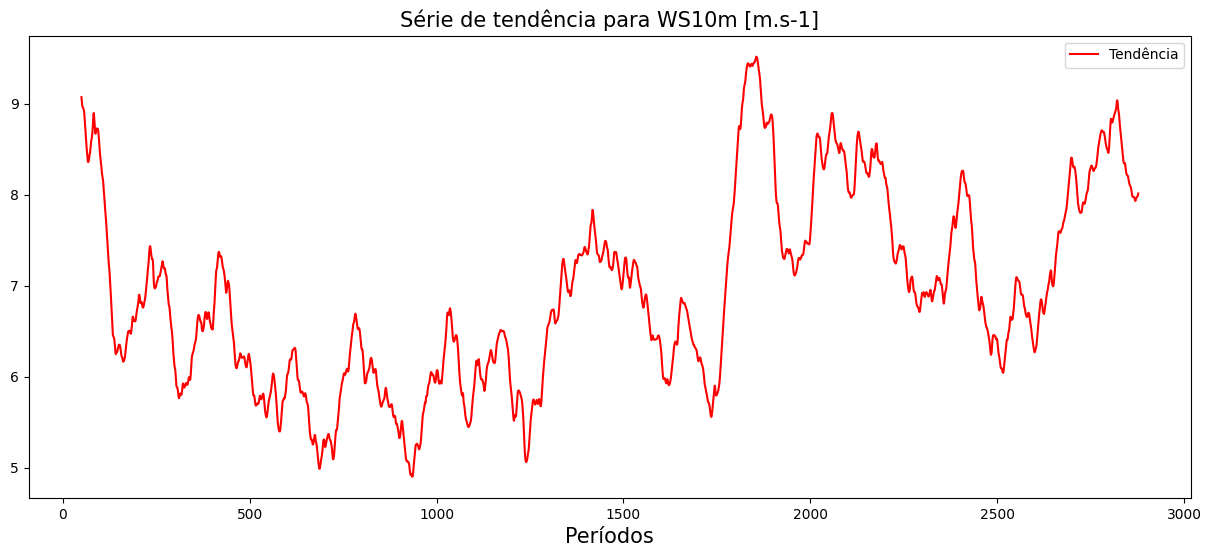

In [ ]:
plt.figure(figsize=(15,6))
result.trend.plot(legend=True, color='r', label='Tendência')
plt.xlabel('Períodos', size=15)
plt.title('Série de tendência para WS10m [m.s-1]', size=15)
plt.show()


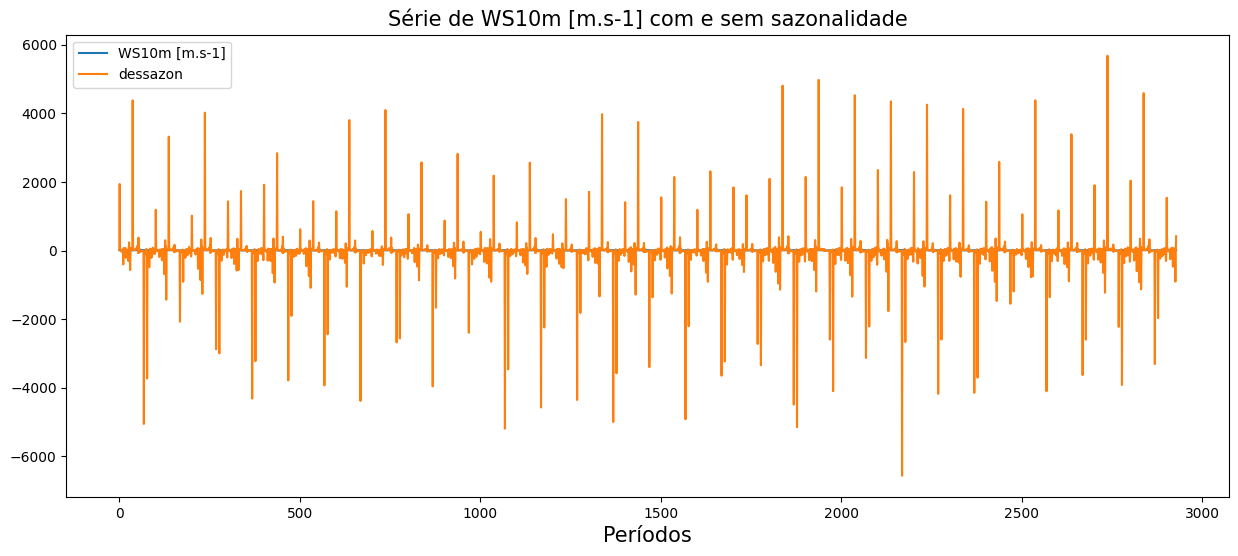

In [ ]:
df['sazonalidade'] = result.seasonal
df['dessazon'] = df['WS10m [m.s-1]'] / df['sazonalidade']
df[['WS10m [m.s-1]', 'dessazon']].plot(figsize=(15,6))
plt.xlabel('Períodos', size=15)
plt.title('Série de WS10m [m.s-1] com e sem sazonalidade', size=15)
plt.show()


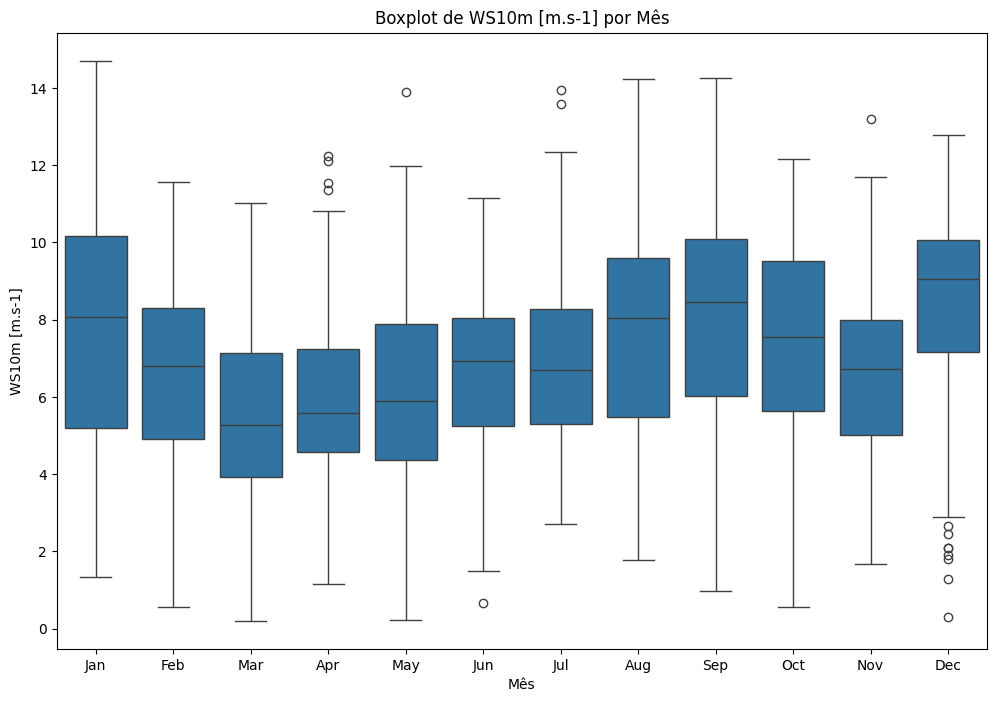

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M')
df['month'] = df['Date'].dt.strftime('%b')
plt.figure(figsize=(12, 8))
sns.boxplot(x='month', y='WS10m [m.s-1]', data=df, order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Boxplot de WS10m [m.s-1] por Mês')
plt.xlabel('Mês')
plt.ylabel('WS10m [m.s-1]')
plt.show()

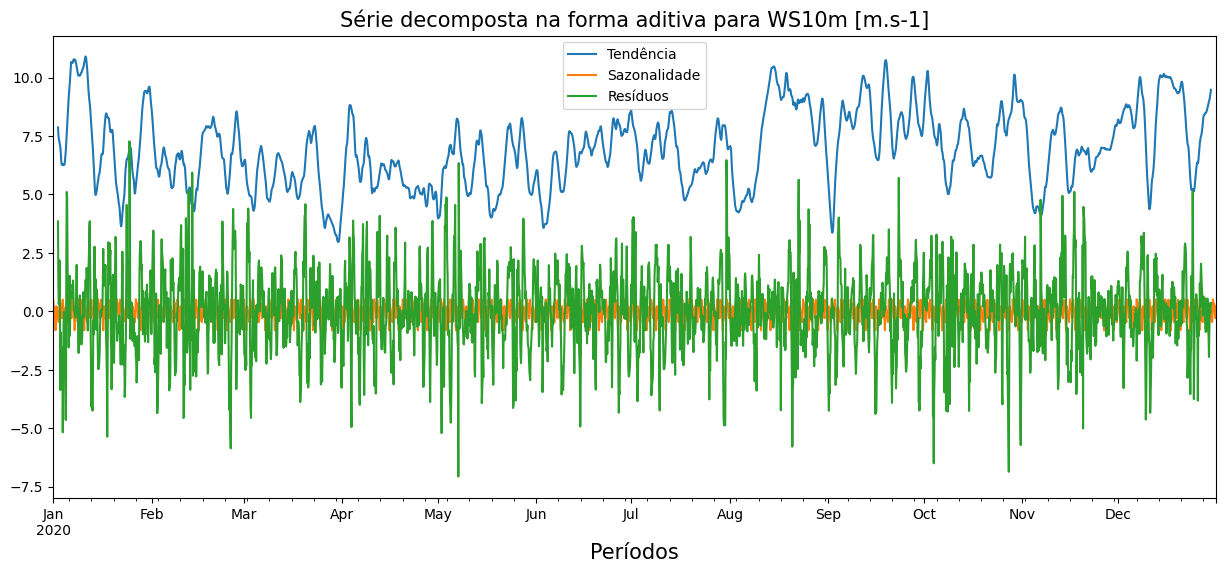

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df.set_index('Date', inplace=True)
result_ws10m = seasonal_decompose(df['WS10m [m.s-1]'], model='additive')

plt.figure(figsize=(15,6))
result_ws10m.trend.plot(legend=True, label='Tendência')
result_ws10m.seasonal.plot(legend=True, label='Sazonalidade')
result_ws10m.resid.plot(legend=True, label='Resíduos')
plt.xlabel('Períodos', size=15)
plt.title('Série decomposta na forma aditiva para WS10m [m.s-1]', size=15)
plt.show()


##Etapa de Identificação


<Figure size 1200x600 with 0 Axes>

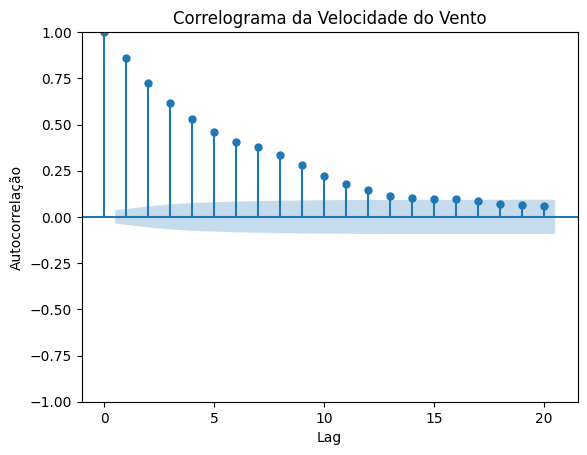

<Figure size 1200x600 with 0 Axes>

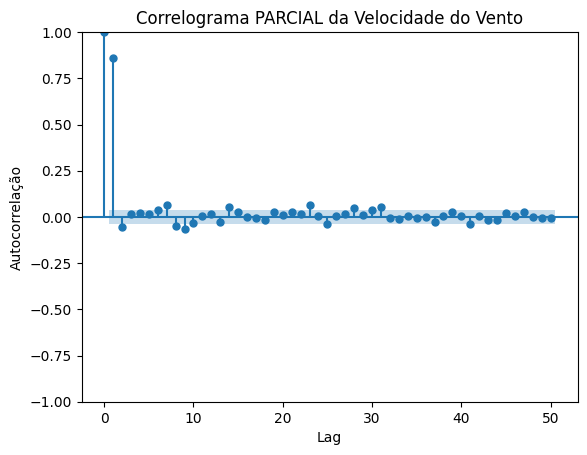

In [ ]:
#correlograma
plt.figure(figsize=(12, 6))
plot_acf(df['WS10m [m.s-1]'], lags=20, alpha=0.05)
#Regra prática: Uma regra comum é usar até 1 + log2(N) lags, onde N é o tamanho da amostra.
plt.title('Correlograma da Velocidade do Vento')
plt.xlabel('Lag')
plt.ylabel('Autocorrelação')
plt.show()


# Gerar o correlograma
plt.figure(figsize=(12, 6))
plot_pacf(df['WS10m [m.s-1]'], lags=50, alpha=0.05)
plt.title('Correlograma PARCIAL da Velocidade do Vento')
plt.xlabel('Lag')
plt.ylabel('Autocorrelação')
plt.show()

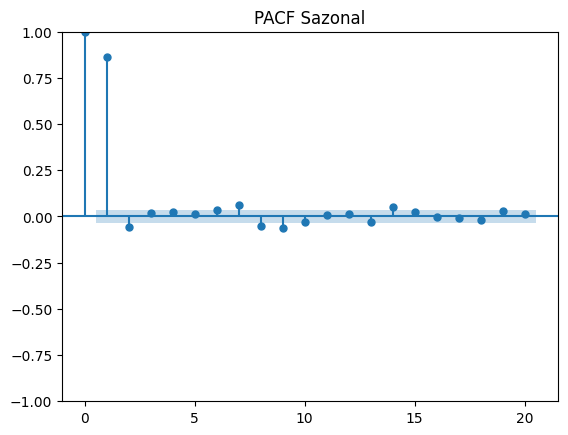

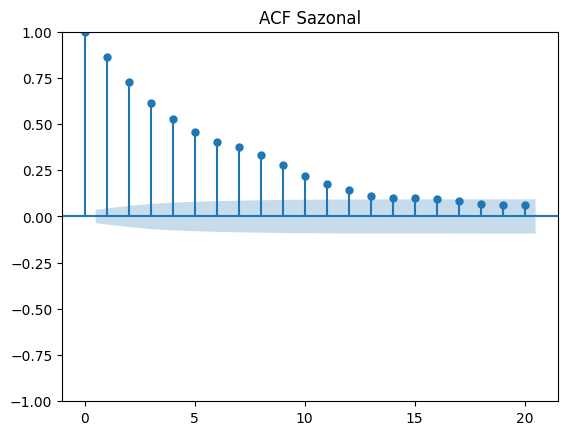

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

s = 10

# Plote o gráfico PACF para lags sazonais
plot_pacf(y, lags=s*2)
plt.title('PACF Sazonal')
plt.show()

# Plote o gráfico ACF para lags sazonais
plot_acf(y, lags=s*2)
plt.title('ACF Sazonal')
plt.show()


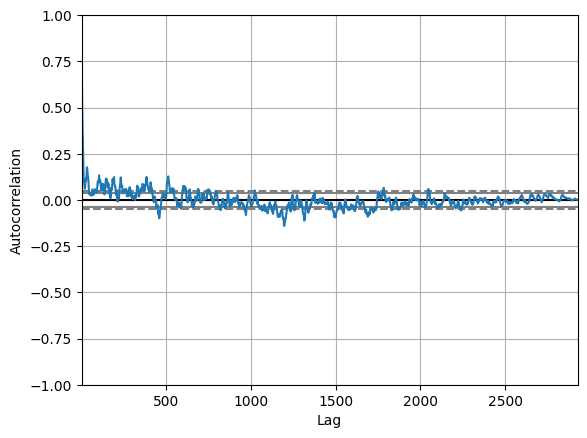

In [ ]:
from pandas.plotting import autocorrelation_plot

# Suponha que 'df' é o seu DataFrame e 'dessazon' é a coluna com a série dessazonalizada
autocorrelation_plot(df['WS10m [m.s-1]'])
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Suponha que 'df' é o seu DataFrame e 'dessazon' é a coluna com a série dessazonalizada
resultado_adfuller = adfuller(df['WS10m [m.s-1]'])

print('Estatística do teste Dickey-Fuller:', resultado_adfuller[0])
print('P-valor:', resultado_adfuller[1])
print('Defasagens usadas no teste:', resultado_adfuller[2])
print('Observações usadas:', resultado_adfuller[3])
print('Valores críticos:', resultado_adfuller[4])


Estatística do teste Dickey-Fuller: -7.045247578061144
P-valor: 5.70902552660296e-10
Defasagens usadas no teste: 27
Observações usadas: 2900
Valores críticos: {'1%': -3.4326069302485953, '5%': -2.8625371602624137, '10%': -2.567300816765755}


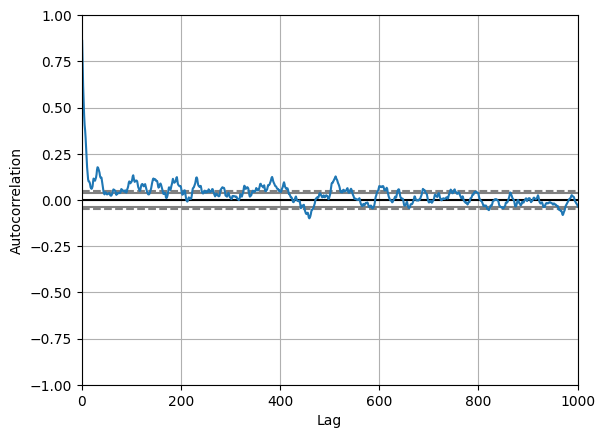

In [ ]:
series = df['WS10m [m.s-1]']
autocorrelation_plot(series)
pyplot.xlim(0, 1000)
pyplot.show()


In [ ]:
resultado_adfuller = adfuller(df['WS10m [m.s-1]'].dropna())  # Usamos dropna() para remover possíveis NaNs

print('Estatística do teste Dickey-Fuller:', resultado_adfuller[0])
print('P-valor:', resultado_adfuller[1])
print('Defasagens usadas no teste:', resultado_adfuller[2])
print('Observações usadas:', resultado_adfuller[3])
print('Valores críticos:', resultado_adfuller[4])




Estatística do teste Dickey-Fuller: -7.045247578061144
P-valor: 5.70902552660296e-10
Defasagens usadas no teste: 27
Observações usadas: 2900
Valores críticos: {'1%': -3.4326069302485953, '5%': -2.8625371602624137, '10%': -2.567300816765755}


In [ ]:
from statsmodels.tsa.stattools import adfuller
df_diferenciada = df['WS10m [m.s-1]'].diff().dropna()
resultado_adfuller_dif = adfuller(df_diferenciada)
print('Estatística do teste Dickey-Fuller após diferenciação:', resultado_adfuller_dif[0])
print('P-valor:', resultado_adfuller_dif[1])
print('Defasagens usadas no teste:', resultado_adfuller_dif[2])
print('Observações usadas:', resultado_adfuller_dif[3])
print('Valores críticos:', resultado_adfuller_dif[4])

Estatística do teste Dickey-Fuller após diferenciação: -16.361145453446728
P-valor: 2.8698166241389825e-29
Defasagens usadas no teste: 28
Observações usadas: 2898
Valores críticos: {'1%': -3.4326084892093296, '5%': -2.8625378487837008, '10%': -2.5673011833295947}


#TIME SERIES APROACH

##ARIMA

ADF Statistic: -7.045247578061144
p-value: 5.70902552660296e-10
Valores previstos: [10.66876233 10.0628538   9.53538052  9.15338806  8.78646182  8.5119102
  8.35001591  8.16576019  7.94872922  7.74844614]


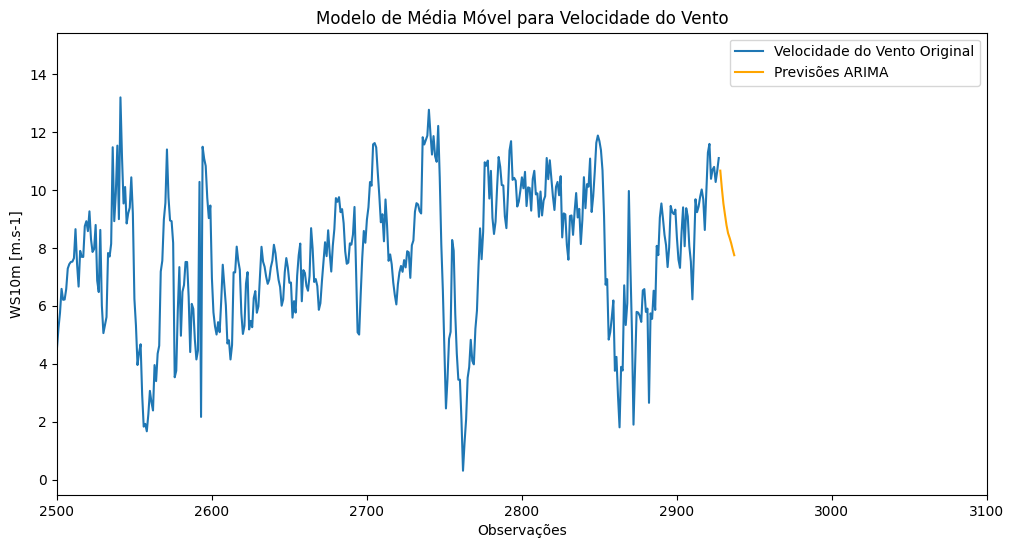

In [ ]:
y = df['WS10m [m.s-1]'].values

result = adfuller(y)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

model = ARIMA(y, order=(2, 0, 8))
model_fit = model.fit()

forecast = model_fit.forecast(steps=10)
print('Valores previstos:', forecast)

plt.figure(figsize=(12, 6))
plt.plot(y, label='Velocidade do Vento Original')
plt.plot(np.arange(len(y), len(y) + 10), forecast, label='Previsões ARIMA', color='orange')
plt.title('Modelo de Média Móvel para Velocidade do Vento')
plt.xlim(2500,3100)
plt.xlabel('Observações')
plt.ylabel('WS10m [m.s-1]')
plt.legend()
plt.show()


##ARIMAX (ARRUMAR)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


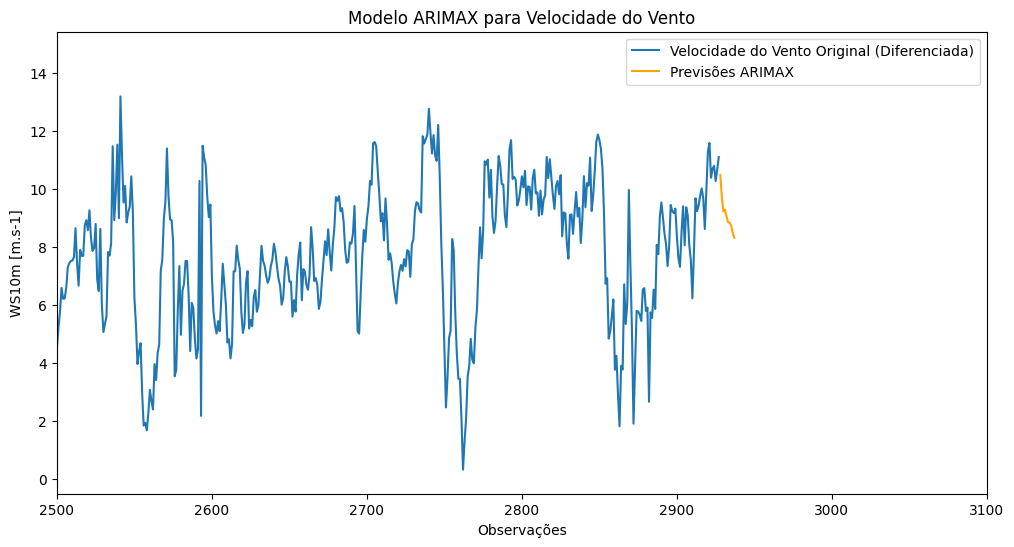

In [ ]:

y = df['WS10m [m.s-1]'].values
from sklearn.preprocessing import StandardScaler
exog_columns = df[['Td2m [°C]', 'RH2m [%]', 'WD10m [°]']]

model = SARIMAX(y, exog=exog, order=(2, 0 ,8))
model_fit = model.fit()

forecast = model_fit.get_forecast(steps=10, exog=exog[-10:])

plt.figure(figsize=(12, 6))
plt.plot(y, label='Velocidade do Vento Original (Diferenciada)')
plt.plot(np.arange(len(y), len(y) + 10), forecast.predicted_mean, label='Previsões ARIMAX', color='orange')
plt.title('Modelo ARIMAX para Velocidade do Vento')
plt.xlabel('Observações')
plt.xlim(2500,3100)
plt.ylabel('WS10m [m.s-1]')
plt.legend()

##SARIMA (ARRUMAR)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Valores previstos: [10.92736685 10.57436887 10.42199264 10.2025449  10.03064855  9.83131605
  9.67991697  9.72064276  9.68843306  9.65887422]


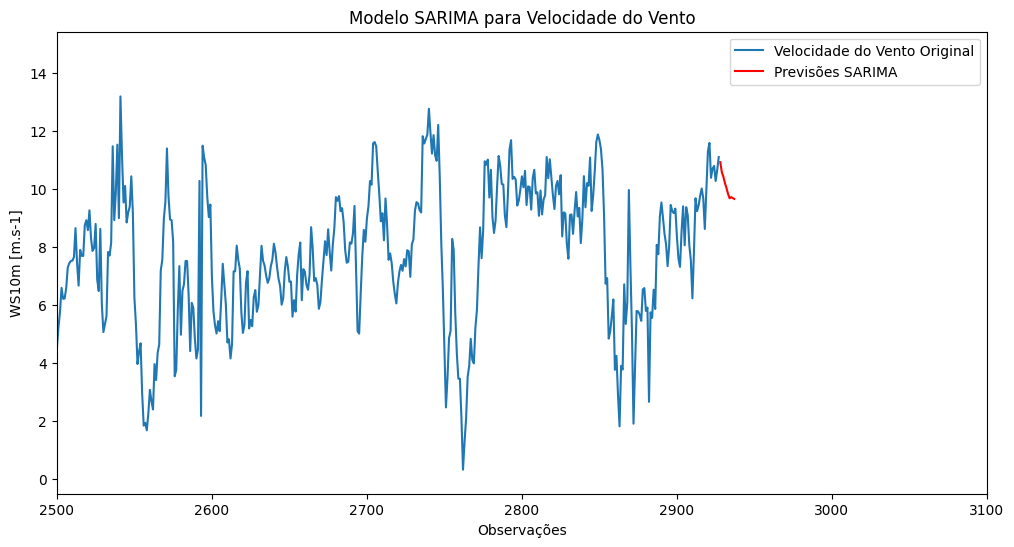

In [ ]:
y = df['WS10m [m.s-1]'].values

# Ajustar o modelo SARIMA
# Os parâmetros (p, d, q) são para a parte ARIMA do modelo
# Os parâmetros (P, D, Q, s) são para a parte sazonal do modelo
# 's' é a periodicidade da sazonalidade (por exemplo, 12 para dados mensais com sazonalidade anual)
model = SARIMAX(y, order=(2, 0, 8), seasonal_order=(5, 0, 1, 10))
model_fit = model.fit()

forecast = model_fit.forecast(steps=10)
print('Valores previstos:', forecast)

plt.figure(figsize=(12, 6))
plt.plot(y, label='Velocidade do Vento Original')
plt.plot(np.arange(len(y), len(y) + 10), forecast, label='Previsões SARIMA', color='red')
plt.title('Modelo SARIMA para Velocidade do Vento')
plt.xlim(2500,3100)
plt.xlabel('Observações')
plt.ylabel('WS10m [m.s-1]')
plt.legend()
plt.show()


##SARIMAX (ARRUMAR)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Valores previstos: [10.58599867 10.18476144  9.86854798  9.50661892  9.19152276  8.98555787
  8.76750491  8.65357107  8.50561064  8.36576545  8.36541626  8.12710796
  7.99946345  7.83715906  7.83382814  7.81855496  7.67062283  7.58713893
  7.98784092  7.97866003  7.93215661  7.96957276  7.91314686  8.00513557
  8.12665999]


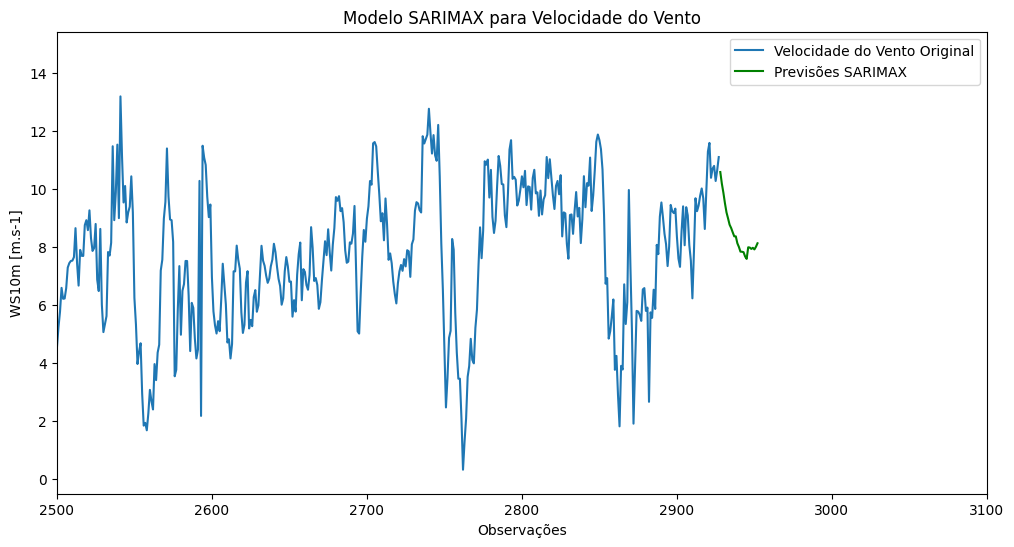

In [ ]:
y = df['WS10m [m.s-1]'].values
exog = df[['Td2m [°C]', 'RH2m [%]','WD10m [°]']].values

# Ajustar o modelo SARIMAX
# Os parâmetros (p, d, q) são para a parte ARIMA do modelo
# Os parâmetros (P, D, Q, s) são para a parte sazonal do modelo
# 's' é a periodicidade da sazonalidade
model = SARIMAX(y, exog=exog, order=(2, 0, 8), seasonal_order=(2, 0, 1, 10))
model_fit = model.fit()

forecast = model_fit.forecast(steps=25, exog=exog[-25:])

print('Valores previstos:', forecast)

plt.figure(figsize=(12, 6))
plt.plot(y, label='Velocidade do Vento Original')
plt.plot(np.arange(len(y), len(y) + 25), forecast, label='Previsões SARIMAX', color='green')
plt.title('Modelo SARIMAX para Velocidade do Vento')
plt.xlim(2500,3100)
plt.xlabel('Observações')
plt.ylabel('WS10m [m.s-1]')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


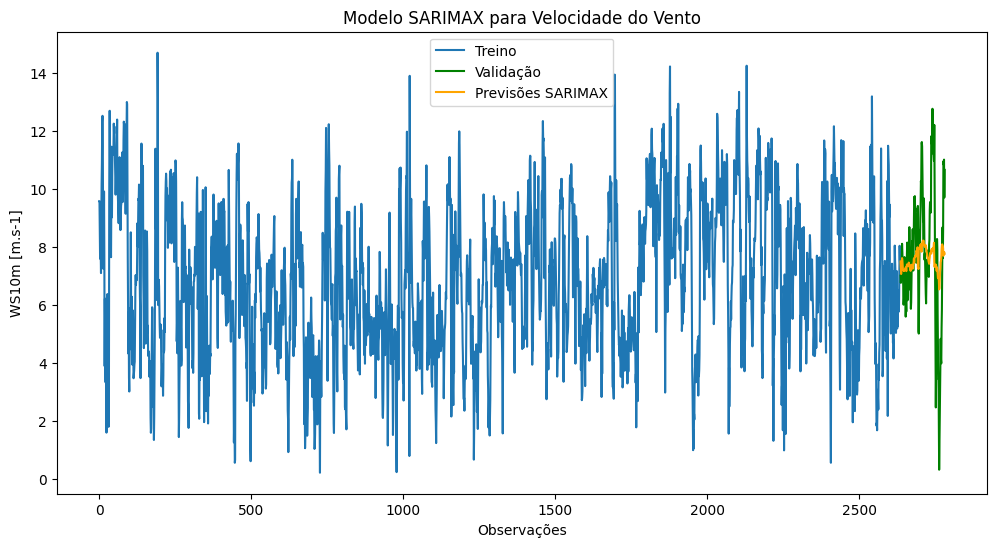

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv('SBLB_WRF_AZUL_00-24h.csv', delimiter=';')
y = df['WS10m [m.s-1]'].values
exog = df[['Td2m [°C]', 'RH2m [%]', 'WD10m [°]']].values

# Dividir os dados em conjuntos de treino, teste e validação
y_train, y_temp = train_test_split(y, test_size=0.1, random_state=42, shuffle=False)
exog_train, exog_temp = train_test_split(exog, test_size=0.1, random_state=42, shuffle=False)
y_val, y_test = train_test_split(y_temp, test_size=0.5, random_state=42, shuffle=False)
exog_val, exog_test = train_test_split(exog_temp, test_size=0.5, random_state=42, shuffle=False)

model = SARIMAX(y_train, exog=exog_train, order=(2, 0, 8), seasonal_order=(2, 0, 1, 10))
model_fit = model.fit()

forecast = model_fit.get_forecast(steps=len(y_val), exog=exog_val)
forecast_values = forecast.predicted_mean

plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Treino')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, label='Validação', color='green')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), forecast_values, label='Previsões SARIMAX', color='orange')
plt.title('Modelo SARIMAX para Velocidade do Vento')
plt.xlabel('Observações')
plt.ylabel('WS10m [m.s-1]')
plt.legend()
plt.show()


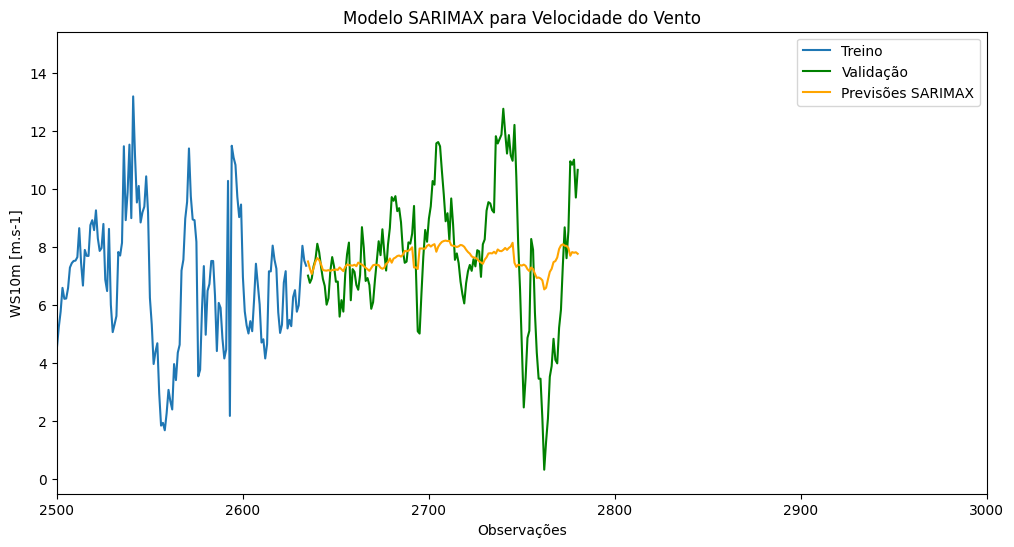

In [ ]:
# Plotar os valores de treino, validação e as previsões
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Treino')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, label='Validação', color='green')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), forecast_values, label='Previsões SARIMAX', color='orange')
plt.title('Modelo SARIMAX para Velocidade do Vento')
plt.xlabel('Observações')
plt.ylabel('WS10m [m.s-1]')
plt.xlim(2500,3000)
plt.legend()
plt.show()

#Akaike Information e  Diagnóstico dos resíduos (USAR PARA ARRUMAR)

AVALIADOR DE MODELOS/OTMIZAR MELHORES PONTOS

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.stattools import jarque_bera

# Suponha que 'df' já contenha a coluna 'WS10m [m.s-1]' e as variáveis exógenas
y = df['WS10m [m.s-1]'].values
exog = df[['Td2m [°C]', 'RH2m [%]', 'WD10m [°]']].values

# Ajustar o modelo SARIMAX
sarimax_model = SARIMAX(y, exog=exog, order=(2, 0, 8), seasonal_order=(2, 0, 1, 10)).fit()

# Realizar o teste de Jarque-Bera nos resíduos do modelo SARIMAX
jb_test = jarque_bera(sarimax_model.resid)

#resultados do teste de Jarque-Bera
print('Estatística Jarque-Bera:', jb_test[0])
print('P-valor:', jb_test[1])
print('Assimetria:', jb_test[2])
print('Curtose:', jb_test[3])


In [ ]:

df = pd.read_csv('SBLB_WRF_AZUL_00-24h.csv', delimiter=';')
y = df['WS10m [m.s-1]'].values
exog = df[['Td2m [°C]', 'RH2m [%]', 'WD10m [°]']].values

# Ajustar o modelo SARIMAX
model = SARIMAX(y, exog=exog, order=(2, 0, 8), seasonal_order=(2, 0, 1, 10))
model_fit = model.fit()

# Exibir o AIC do modelo ajustado
print(f'AIC do modelo: {model_fit.aic}')

# Realizar o teste de Ljung-Box nos resíduos
lb_test = acorr_ljungbox(model_fit.resid, lags=[10], return_df=True)

# teste de Ljung-Box
print(lb_test)


In [ ]:
import itertools
from statsmodels.tsa.arima.model import ARIMA

y = df['WS10m [m.s-1]'].values

q = [6,7,8]
p = [2,3]
d = [1]

pdq = list(itertools.product(p, d, q))


for param in pdq:
    modelo_arima = ARIMA(y, order=param)
    modelo_arima_fit = modelo_arima.fit()
    print('ARIMA{} - AIC: {} - BIC: {} - HQIC: {}'.format(param, modelo_arima_fit.aic, modelo_arima_fit.bic, modelo_arima_fit.hqic))


In [ ]:
y = df['WS10m [m.s-1]'].values
exog = df[['Td2m [°C]', 'RH2m [%]', 'WD10m [°]']].values

q = [8]
p = [2]
d = [0]

# Definindo os parâmetros sazonais
P = [1, 2,3,4]  # Exemplo de valores para P
D = [0]        # Exemplo de valores para D
Q = [1,2,3,4]     # Exemplo de valores para Q
s = 10        # Exemplo de valor para s

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [s]))

for param in pdq:
    for seasonal_param in seasonal_pdq:
        modelo_sarimax = SARIMAX(y, exog=exog, order=param, seasonal_order=seasonal_param)
        modelo_sarimax_fit = modelo_sarimax.fit()
        print('SARIMAX{}x{} - AIC: {} - BIC: {} - HQIC: {}'.format(param, seasonal_param, modelo_sarimax_fit.aic, modelo_sarimax_fit.bic, modelo_sarimax_fit.hqic))


In [ ]:
modelo_arima = ARIMA(y, order=(2, 0, 8))
modelo_arima_fit = modelo_arima.fit()

jb_test = jarque_bera(modelo_arima_fit.resid)

print('Estatística Jarque-Bera:', jb_test[0])
print('P-valor:', jb_test[1])
print('Assimetria:', jb_test[2])
print('Curtose:', jb_test[3])


#VAMOS IGNORAR ISSO POR ENQUANTO

##METODO DE KRIGING

In [ ]:
import pandas as pd
from pykrige.ok import OrdinaryKriging
import numpy as np

# Load the original data
df1 = pd.read_csv('SBLB_WRF_AZUL_00-24h.csv', delimiter=';')
df2 = pd.read_csv('SBLB_OBS_L2.csv', delimiter=';')

# Convert the 'Date' column to datetime and set as index
df1['Date'] = pd.to_datetime(df1['Date'], errors='coerce')
df1.dropna(subset=['Date'], inplace=True)
df1.set_index('Date', inplace=True)

df2['Date'] = pd.to_datetime(df2['Date'], errors='coerce')
df2.dropna(subset=['Date'], inplace=True)
df2.set_index('Date', inplace=True)

# Set the frequency of the index to daily
df1 = df1.asfreq('D')
df2 = df2.asfreq('D')

# Colunas meteorológicas para as quais você deseja estimar os dados faltantes
colunas_meteorologicas = ['T2m [°C]', 'Td2m [°C]', 'Press[hPa]', 'WS10m [m.s-1]', 'WD10m [°]']

# Função para interpolar valores ausentes usando Krigagem
def interpolar_com_krigagem(serie_temporal):
    # Transformar a série temporal em um array 2D (tempo, valor)
    tempo = np.arange(len(serie_temporal)).reshape(-1, 1).astype('float64')
    valores = serie_temporal.values.reshape(-1, 1).astype('float64')

    # Criar e ajustar o modelo de Krigagem
    OK = OrdinaryKriging(tempo, np.zeros_like(tempo), valores, variogram_model='linear')
    kriging_result, ss = OK.execute('grid', tempo, np.zeros_like(tempo))

    # Retornar os valores interpolados
    return kriging_result.data.flatten()

# Preencher os valores ausentes em cada coluna
for coluna in colunas_meteorologicas:
    # Verificar cada linha por dados faltantes
    for i in range(len(df2)):
        if pd.isna(df2[coluna].iloc[i]):
            # Utilizar dados até o ponto atual para fazer a interpolação
            serie_temporal = df2[coluna].iloc[:i].dropna()
            if not serie_temporal.empty:
                # Interpolar os valores ausentes
                valores_interpolados = interpolar_com_krigagem(serie_temporal)
                # Preencher o valor ausente com o valor interpolado
                df2[coluna].iloc[i] = valores_interpolados[-1]  # Usar o último valor interpolado

# Salvar o DataFrame preenchido em um novo arquivo CSV
df2.to_csv('seu_arquivo_preenchido.csv')


KeyboardInterrupt: 

##MACHINE LEARNING

In [ ]:

# Carregar os dados
df = pd.read_csv('SBLB_WRF_AZUL_00-24h.csv', delimiter=';')

X = df[['T2m [°C]', 'Td2m [°C]', 'WD10m [°]','WS10m [m.s-1]']].values
y = df['WS10m [m.s-1]'].values


In [ ]:

# Selecionar as variáveis preditoras (X) e a variável alvo (y)
X_train = df[['T2m [°C]', 'Td2m [°C]', 'WS10m [m.s-1]']].values
y_train = df['WS10m [m.s-1]'].values

X_test = df1[['T2m [°C]', 'Td2m [°C]','WD10m [°]']].values
y_test = df1['WS10m [m.s-1]'].values

NameError: name 'df1' is not defined

In [ ]:

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Redimensionar os dados para a entrada da LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:

batch_size = 32
epochs = 50

# Construir o modelo de rede neural com LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(1)
])

# Compilar o modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Treinar o modelo
print('Iniciando o treinamento...')
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)  # Usando 20% dos dados para validação

# Avaliar o modelo
print('Avaliando o modelo...')
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Teste MSE: {loss:.4f}, Teste MAE: {mae:.4f}')

Iniciando o treinamento...
Epoch 1/50
74/74 [==============================] - 2s 8ms/step - loss: 45.9127 - mae: 6.2837 - val_loss: 40.0030 - val_mae: 5.8788
Epoch 2/50
74/74 [==============================] - 0s 4ms/step - loss: 13.2124 - mae: 2.9207 - val_loss: 6.3474 - val_mae: 2.1423
Epoch 3/50
74/74 [==============================] - 0s 4ms/step - loss: 5.4404 - mae: 1.8760 - val_loss: 3.9930 - val_mae: 1.6870
Epoch 4/50
74/74 [==============================] - 0s 4ms/step - loss: 3.6642 - mae: 1.5406 - val_loss: 2.6203 - val_mae: 1.3578
Epoch 5/50
74/74 [==============================] - 0s 4ms/step - loss: 2.5699 - mae: 1.2726 - val_loss: 1.3963 - val_mae: 0.9792
Epoch 6/50
74/74 [==============================] - 0s 4ms/step - loss: 2.0052 - mae: 1.1058 - val_loss: 0.6461 - val_mae: 0.6487
Epoch 7/50
74/74 [==============================] - 0s 4ms/step - loss: 1.5411 - mae: 0.9644 - val_loss: 0.3491 - val_mae: 0.4582
Epoch 8/50
74/74 [==============================] - 1s 8ms/s

12/12 [==============================] - 0s 2ms/step


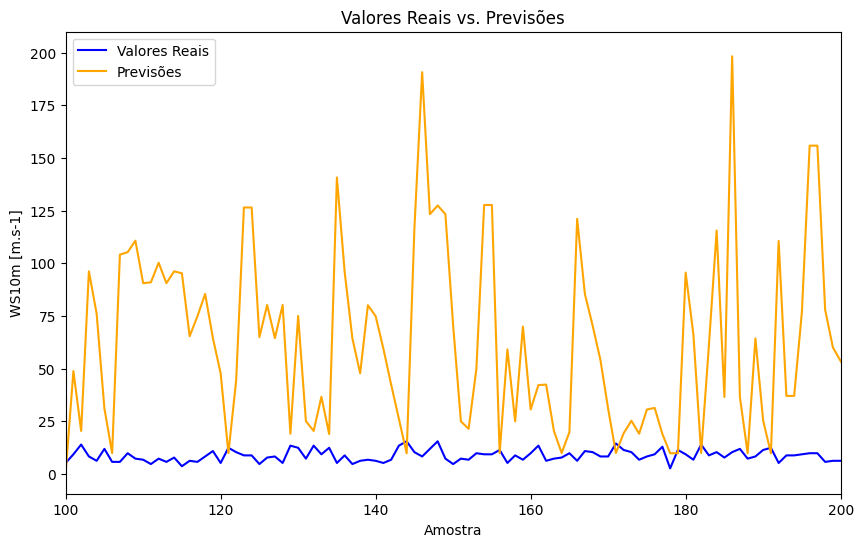

In [ ]:
import matplotlib.pyplot as plt

# Obter as previsões do modelo
y_pred = model.predict(X_test)

# Plot dos valores reais vs. previsões
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores Reais', color='blue')
plt.plot(y_pred, label='Previsões', color='orange')
plt.xlabel('Amostra')
plt.xlim(100,200)
plt.ylabel('WS10m [m.s-1]')
plt.title('Valores Reais vs. Previsões')
plt.legend()
plt.show()

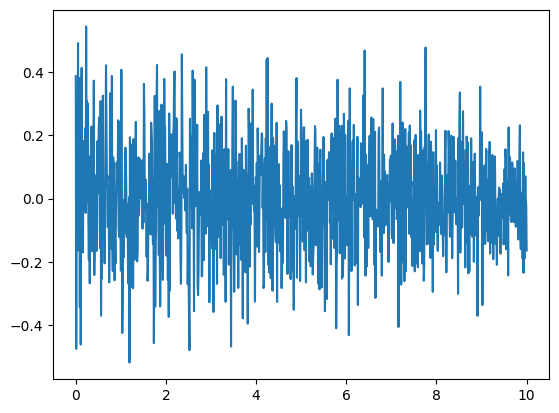

In [ ]:
A = 3
w = 0.1
T = np.linspace(0,10,1000)

def x(t):
  return (np.random.normal(0,0.2))*np.cos(w*t)

X = [x(t) for t in T]

plt.plot(T,X)
